# Experiments using classifiers to evaluate teh affectivness of the models

## Section A - Dataset configuration

In [1]:
import numpy as np 
import kagglehub

pathA = kagglehub.dataset_download("dextershepherd/3d-printed-tactile-dataset-tactip-readings")
print(pathA)


/its/home/drs25/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.40G/2.40G [00:55<00:00, 46.3MB/s]

Extracting files...


/its/home/drs25/.cache/kagglehub/datasets/dextershepherd/3d-printed-tactile-dataset-tactip-readings/versions/4


In [2]:
import subprocess
result = subprocess.run(["mv", pathA, "/mnt/data0/drs25/data/"], capture_output=True, text=True)
pathA="/mnt/data0/drs25/data/"

In [1]:
datapath="/its/home/drs25/.cache/kagglehub/datasets/dextershepherd/3d-printed-tactile-dataset-tactip-readings/versions/2"
import os 
import pandas as pd 
import numpy as np
import cv2 
files=os.listdir(datapath)
dataset= pd.DataFrame({
    'Index':[],
    'Filament':[],
    'Pattern':[],
    'Printer':[],
    "Pressure":[]
})
X=[]
idx=0
percentage=0.4
for i,file in enumerate(files):
    data=np.load(datapath+"/"+file)
    info=file.replace(".npy","").split("_")
    data=data.reshape((1*2*5*5,480,640,3))
    print(file,data.shape)
    for image in data:
        gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        h=int(image.shape[0]*percentage)
        w=int(image.shape[1]*percentage)
        gray = cv2.resize(gray,(w,h),interpolation=cv2.INTER_AREA)
        X.append(gray)
        new_row = pd.DataFrame([{
        'Index': int(idx),
        'Filament': info[0],
        'Pattern': info[1],
        'Printer': info[3],
        'Pressure': info[2]
    }])
        idx+=1
        dataset = pd.concat([dataset, new_row], ignore_index=True)

dataset.head()
X=np.array(X)
np.save("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/images",X)
dataset.to_csv("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/meta.csv")
print(X.shape)

/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


PLAminus_z4_P50_creality.npy (50, 480, 640, 3)
PLAminus_z5_P40_creality.npy (50, 480, 640, 3)
PLAminus_z0_P50_creality.npy (50, 480, 640, 3)
PLAminus_z4_P40_creality.npy (50, 480, 640, 3)
PLAminus_z2_P50_creality.npy (50, 480, 640, 3)
PLAminus_z3_P50_creality.npy (50, 480, 640, 3)
PLAminus_z2_P40_creality.npy (50, 480, 640, 3)
PLAminus_z1_P50_creality.npy (50, 480, 640, 3)
PLAminus_z0_P40_creality.npy (50, 480, 640, 3)
PLAminus_z5_P50_creality.npy (50, 480, 640, 3)
PLAminus_z5_P30_creality.npy (50, 480, 640, 3)
PLAminus_z0_P30_creality.npy (50, 480, 640, 3)
PLAminus_z3_P40_creality.npy (50, 480, 640, 3)
PLAminus_z3_P30_creality.npy (50, 480, 640, 3)
PLAminus_z1_P40_creality.npy (50, 480, 640, 3)
PLAminus_z1_P30_creality.npy (50, 480, 640, 3)
PLAminus_z2_P30_creality.npy (50, 480, 640, 3)
PLAminus_z4_P30_creality.npy (50, 480, 640, 3)
(900, 192, 256)


In [2]:
dataset.head()

,Index,Filament,Pattern,Printer,Pressure
0,0.0,PLAminus,z4,creality,P50
1,1.0,PLAminus,z4,creality,P50
2,2.0,PLAminus,z4,creality,P50
3,3.0,PLAminus,z4,creality,P50
4,4.0,PLAminus,z4,creality,P50


## Section B - modelling

In [1]:
import pandas as pd
import numpy as np
X=np.load("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/images.npy")
dataset=pd.read_csv("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/meta.csv")
print("Dataset size:",X.shape)
dataset.head()

/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


FileNotFoundError: [Errno 2] No such file or directory: '/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/meta.csv'

### Prediction across classes

In [2]:
subset = dataset[(dataset['Filament'] == "PLAminus") & (dataset['Printer'] == "creality")]
subX=[]
y=[]
for _, row in subset.iterrows():
    # get the class label (e.g., from the 'Pattern' column)
    y.append(int(row['Pattern'].replace("z","")))
    # get the corresponding feature data (e.g., from column 14 to 25)
    subX.append(X[int(row['Index'])])
y=np.array(y)
subX=np.array(subX)
print(y.shape,subX.shape)

#14 25 

(900,) (900, 192, 256)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [20]:


train_X, test_X, train_y, test_y = train_test_split(subX.reshape((len(subX),-1)), y, test_size=0.2, random_state=np.random.randint(0,100))

svm_model = SVC(decision_function_shape='ovo')
# Train the SVM model
svm_model.fit(train_X, train_y)
# Make predictions on the test set
y_pred = svm_model.predict(test_X)

accuracy = accuracy_score(test_y, y_pred)
print("Test",accuracy * 100, "%")
y_pred = svm_model.predict(test_X)
accuracy = accuracy_score(train_y, y_pred)
print("Train",accuracy * 100, "%")

31.851851851851855 %


In [21]:
clf = RandomForestClassifier(max_depth=50, random_state=0)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print("Test",accuracy * 100, "%")
y_pred = clf.predict(test_X)
accuracy = accuracy_score(train_y, y_pred)
print("Train",accuracy * 100, "%")

92.96296296296296 %


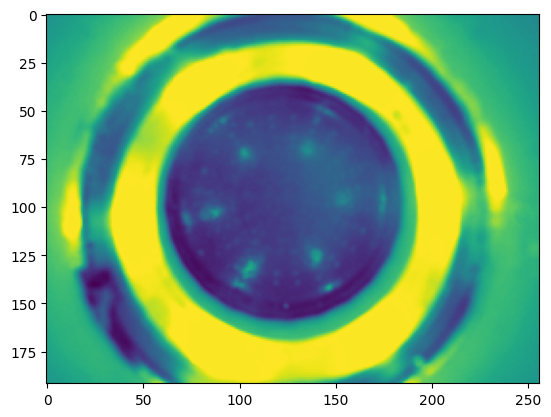

In [18]:
import matplotlib.pyplot as plt 

plt.imshow(X[np.random.randint(0,500)])
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
def testCNN(train_X,train_y):
    y_cat = to_categorical(y)
    #train_X, test_X, train_y, test_y = train_test_split(dataX.reshape((*dataX.shape,1)), datay, test_size=0.2, random_state=np.random.randint(0,100))
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(train_X.shape[1:])),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(train_y.shape[1], activation='softmax')  # number of classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y))
    return model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y_cat = to_categorical(y)
train_X, test_X, train_y, test_y = train_test_split(subX.reshape((*subX.shape,1)), y_cat, test_size=0.6, random_state=np.random.randint(0,100))
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(train_X.shape[1:])),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_y.shape[1], activation='softmax')  # number of classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y))
loss, acc = model.evaluate(test_X, test_y)
print(f"Test accuracy: {acc*100:.2f}%")
model.save("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/my_cnn_model.keras") 

Epoch 1/100
12/12 [==============================] - 11s 909ms/step - loss: 1161.1510 - accuracy: 0.1528 - val_loss: 30.2393 - val_accuracy: 0.1444
Epoch 2/100
12/12 [==============================] - 14s 1s/step - loss: 6.0206 - accuracy: 0.1861 - val_loss: 1.7830 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - 10s 876ms/step - loss: 1.7801 - accuracy: 0.2500 - val_loss: 1.7511 - val_accuracy: 0.2778
Epoch 4/100
12/12 [==============================] - 10s 827ms/step - loss: 1.7428 - accuracy: 0.2750 - val_loss: 1.6788 - val_accuracy: 0.2981
Epoch 5/100
12/12 [==============================] - 13s 1s/step - loss: 1.6593 - accuracy: 0.3194 - val_loss: 1.6917 - val_accuracy: 0.2759
Epoch 6/100
12/12 [==============================] - 13s 1s/step - loss: 1.5931 - accuracy: 0.3306 - val_loss: 1.6908 - val_accuracy: 0.3185
Epoch 7/100
12/12 [==============================] - 10s 892ms/step - loss: 1.5514 - accuracy: 0.3861 - val_loss: 1.7956 - val_accuracy: 0.17

In [38]:
model.save("/its/home/drs25/Documents/GitHub/3D-textures/Experimental/data/my_cnn_model.keras") 

#### Test all parameters

In [ ]:


unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
n=len(unique_filament)*len(unique_printer)
matrix=np.zeros((n,n,20,2))
def getsubset(filament,printer):
    subset = dataset[(dataset['Filament'] == filament) & (dataset['Printer'] == printer)]
    subX=[]
    y=[]
    for _, row in subset.iterrows():
        # get the class label (e.g., from the 'Pattern' column)
        y.append(int(row['Pattern'].replace("z","")))
        # get the corresponding feature data (e.g., from column 14 to 25)
        subX.append(X[int(row['Index'])])
    y=np.array(y)
    subX=np.array(subX)
    return subX,y
def getallelse(filament,printer):
    subset = dataset[(dataset['Filament'] != filament) | (dataset['Printer'] != printer)]
    subX=[]
    y=[]
    for _, row in subset.iterrows():
        # get the class label (e.g., from the 'Pattern' column)
        y.append(int(row['Pattern'].replace("z","")))
        # get the corresponding feature data (e.g., from column 14 to 25)
        subX.append(X[int(row['Index'])])
    y=np.array(y)
    subX=np.array(subX)
    return subX,y

n=0
for filament in unique_filament:
    for printer in unique_printer: #loop through al permutations
        train_X,train_y=getsubset(filament,printer)
        m=0
        for filament_other in unique_filament:
            for printer_other in unique_printer:
                if not(filament==filament_other and printer==printer_other): #make sure it is not trained on itself
                    test_X,test_y=getsubset(filament_other,printer_other)
                    for i in range(20):
                        model=testCNN(train_X,train_y)
                        loss, acc = model.evaluate(test_X, test_y)
                        matrix[n][m][i][0]=acc
                        loss, acc = model.evaluate(train_X, train_y)
                        matrix[n][m][i][1]=acc
                m+=1
                
        n+=1
np.save(path_to_file,matrix)

### Test all classes on pretrained models

## Section C - Visualise